0


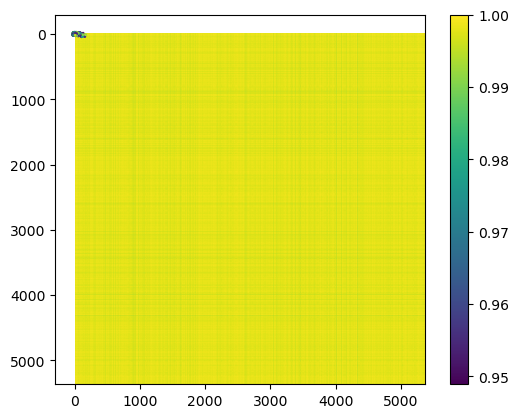

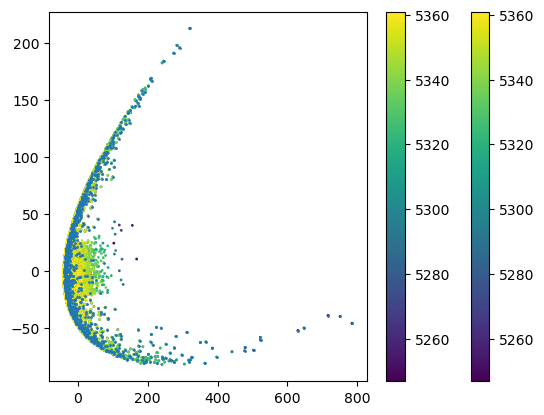

1


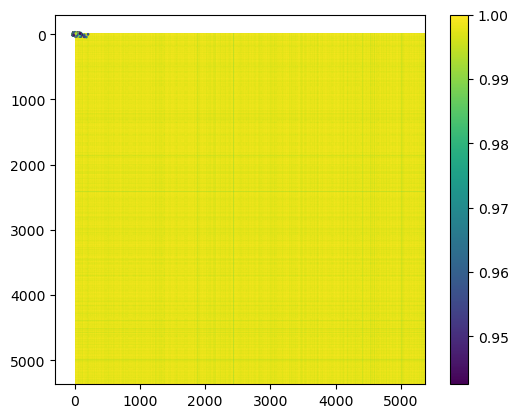

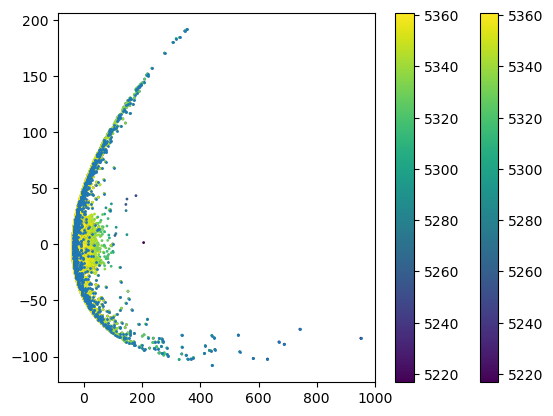

2


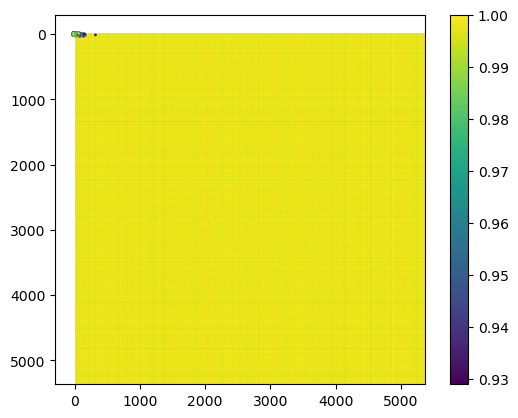

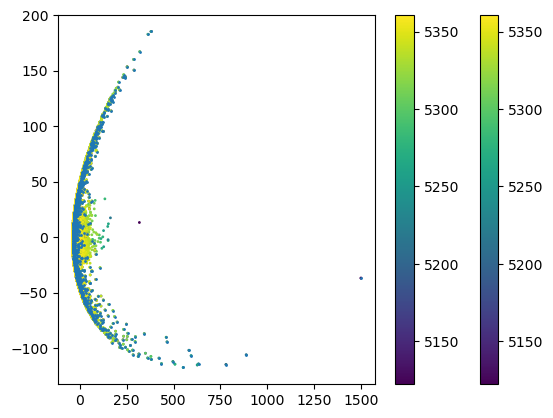

3


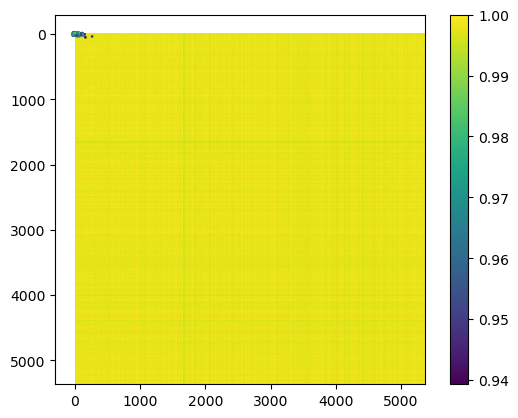

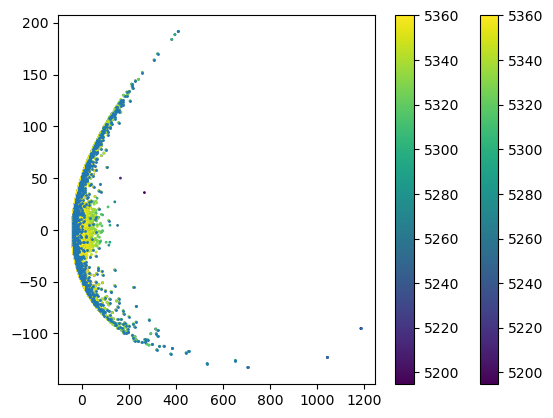

4


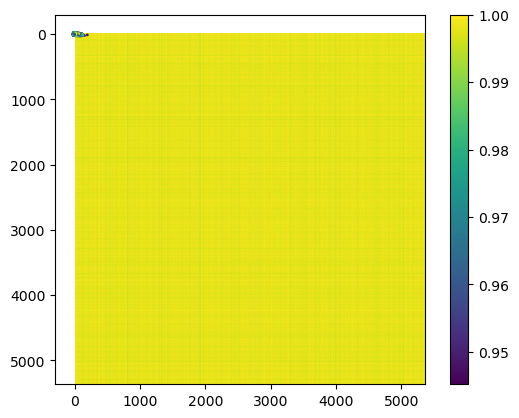

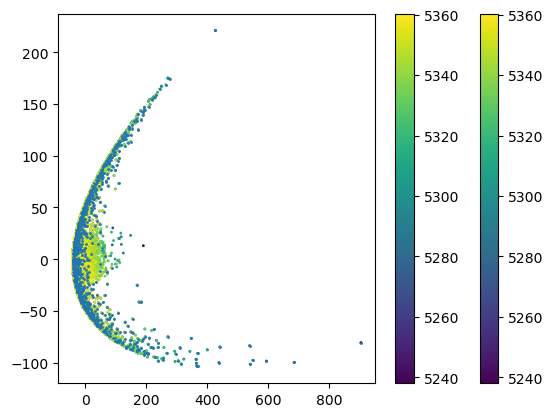

5


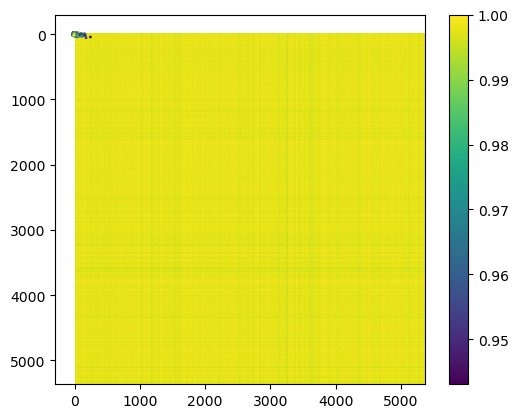

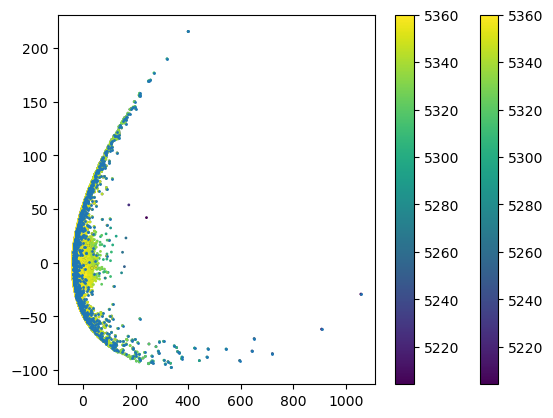

6


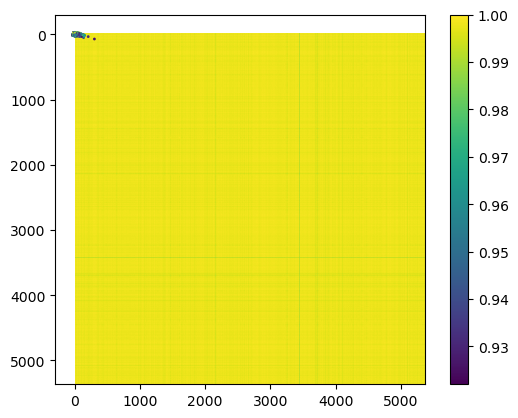

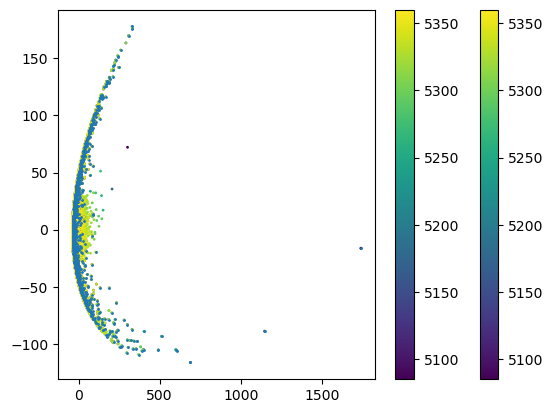

7


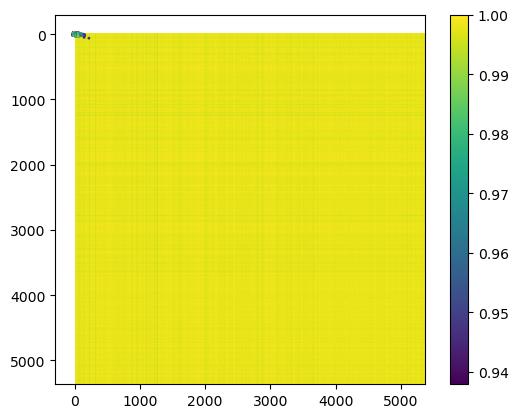

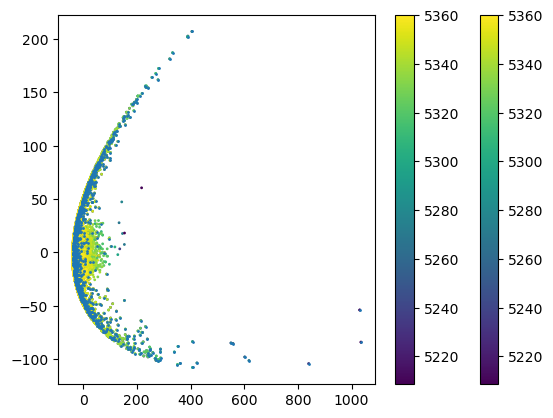

8


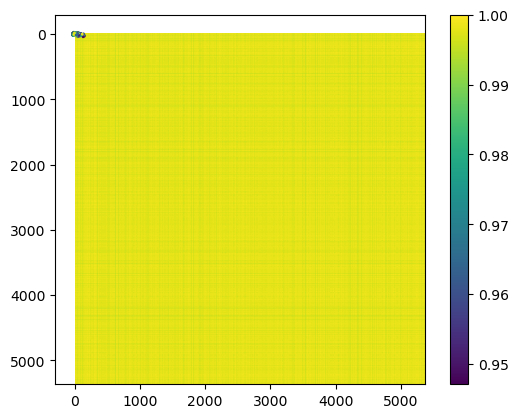

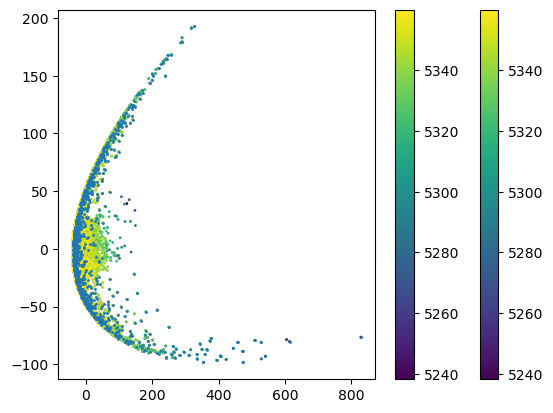

9


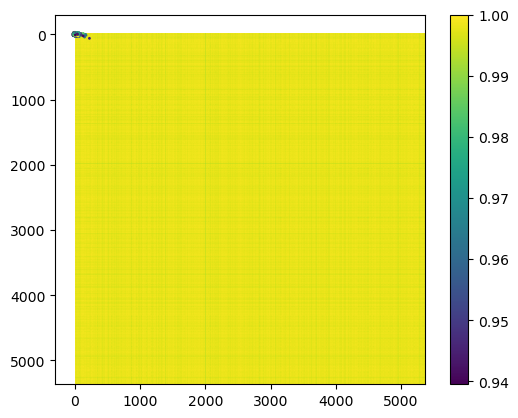

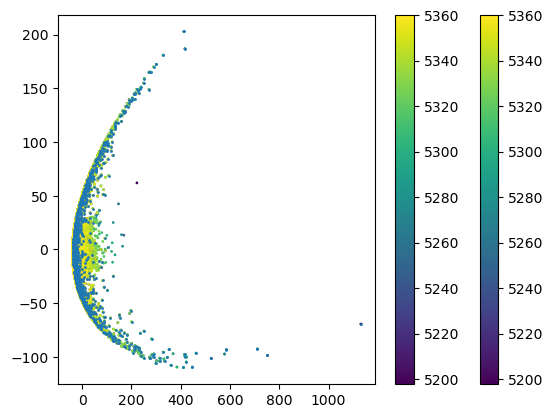

In [5]:
import ase
from ase.io import read
import dscribe
from dscribe.descriptors import SOAP
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

from spyrmsd import rmsd

import pandas as pd

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA

from sklearn.decomposition import PCA
from ase.io import write

water6 = "/home/boittier/Documents/phd/ff_energy/ff_energy/sampling/6_TIP3.xyz"

for J in range(10):
    print(J)
    trajwater6 = read(water6,index=f'{J*2}::20') 

    def soap(rcut=6.0, nmax=8, lmax=4, species=("H", "O"), average="inner", weighting=None):
        # Setting up the SOAP descriptor
        soap = SOAP(
            species=species,
            periodic=False,
            r_cut=rcut,
            n_max=nmax,
            l_max=lmax,
            average=average,
            weighting=weighting,
        )
        return soap


    soap = soap()

    water6soap = soap.create(trajwater6)

    positions = [ _.get_positions() for _ in trajwater6]

    atomic_numbers = trajwater6[0].get_atomic_numbers()

    sym_rmsd = []
    cosign_sim = []

    for i in range(len(positions)):
        # sym_rmsd.append(rmsd.symmrmsd(positions[i], positions, atomic_numbers, atomic_numbers, AM, AM, center=True, minimize=True))
        cosign_sim.append(cosine_similarity([water6soap[i]], water6soap))

    shape = np.array(cosign_sim).shape[0]


    plt.imshow(np.array(cosign_sim).reshape(shape,shape,1))
    plt.colorbar()

    DATA = pd.DataFrame([_[0] for _ in cosign_sim])

    TESTDATA = DATA.to_numpy() 

    kmeans = KMeans(n_clusters=1000, random_state=0, n_init="auto").fit(water6soap)

    pca = PCA(n_components=2)
    _PCA = pca.fit_transform(StandardScaler().fit_transform(water6soap)).T

    plt.scatter(_PCA[0], _PCA[1], c=kmeans.labels_, s=1)
    plt.show()
    plt.scatter(_PCA[0], _PCA[1], c=DATA.sum(), s=1, alpha=1)
    plt.colorbar()


    pca = PCA(n_components=2)
    _PCA = pca.fit_transform(StandardScaler().fit_transform(TESTDATA)).T
    plt.scatter(_PCA[0], _PCA[1], c=kmeans.labels_, s=1)

    # plt.scatter(_PCA[0], _PCA[1], c=dn["leaves_color_list"], s=1, alpha=1)
    plt.scatter(_PCA[0], _PCA[1], c=TESTDATA.sum(axis=1), s=1, alpha=1)
    plt.colorbar()


    DATA["SUM"] =  DATA.sum()

    DATA["LABELS"] = kmeans.labels_ 

    DATA = DATA.sort_values("SUM")

    keys = []
    indexes = []
    for row in DATA[["SUM", "LABELS"]].iterrows():
        k = row[1][1]
        if k not in keys:
            keys.append(k)
            indexes.append(row[0])


    for i, idx in enumerate(indexes):
        write(f"dimers/{i}-{J}.xyz", trajwater6[idx])
        write(f"dimers_pdb/{i}-{J}.pdb", trajwater6[idx])

    plt.scatter(_PCA[0][indexes], _PCA[1][indexes], 
                # c=dn["leaves_color_list"][indexes],
                s=1, alpha=1)
    plt.show()
